# Model Development

**Note: This notebook is a continuation of the exploratory_data_analysis notebook. For more information on that topic. please feel free to look at exploratory_data_analysis.ipynb** 

After exploring and analyzing the music dataset, we hypothesized that the best model that can classify a song's or music track's genre will be the convolutional neural network. To justify why it might be the best choice for our supervised learning problem, let's take a look at an example mel-spectrogram.

<center><img src="example_mel-spectrogram.png" style="width:600px;height:450px"></center>

As you can see in this image,
* There are multiple squiggly lines at the lower segment of the image so it indicates that there is a vocalist in the music track.
* There are many bright vertical lines that is consistently spaced so it means that the music track has a consistent beat.

If the mel-spectrogram was shifted slightly to the left by one pixel, then intuitively, it looks like the same mel-spectrogram. Hence, if the shifted mel-spectrogram was translated to an audio file, then it would sound the same as the original. This means that if we need a model that can identify a track's genre, then it must be translationally invariant. Fortunately, the convolutional neural network model is designed to be translationally invariant because it inherently uses a filter that passes through an image to perform a convolutional operation. Fore more details about CNNs, see https://en.wikipedia.org/wiki/Convolutional_neural_network.

Before we can use CNNs to classify a song's genre, we first need to preprocess our music dataset so that it can be easily used as input for our model.

#### Preprocessing Phase

In [1]:
import numpy as np
import pandas as pd

from librosa import load, power_to_db
from librosa.feature import melspectrogram

def compute_melspectrogram(file_location):
    y, sampling_rate = load(file_location)
    melspectrogram_db = power_to_db(
        melspectrogram(y=y, sr=sampling_rate), 
        ref=np.max
    )

    return melspectrogram_db

#One Hot Encode The Genres
music_df = pd.read_csv('../data/metadata.csv')
genre_df = pd.get_dummies(music_df.genre, prefix='is-')

music_df = music_df.join(genre_df)
music_df.drop(['genre'], axis=1, inplace=True)

#Convert File Locations To Melspectrograms
music_df["melspectrograms"] = music_df["file_location"].apply(compute_melspectrogram)
music_df.drop(['file_location'], axis=1, inplace=True)

#Save Predictor Variables As Numpy Arrays
melspectrograms = np.array(
    list(music_df['melspectrograms'])
)
extracted_features = np.array(
    music_df[['tempo', 'zero_crossing_rate', 'average_spectral_flatness']]
)

np.save('melspectrograms.npy', melspectrograms)
np.save('extracted_features.npy', extracted_features)

#Save Response Variables As Numpy Arrays
one_hot_encoded_genres = np.array(genre_df)
np.save('one_hot_encoded_genres.npy', one_hot_encoded_genres)

#### Load Data (Run Once After Running Above Cell)

In [2]:
import numpy as np

melspectrograms = np.load('melspectrograms.npy')
melspectrograms = melspectrograms.reshape(
    *melspectrograms.shape, 
    1
)

extracted_features = np.load('extracted_features.npy')
extracted_features = extracted_features.reshape(
    *extracted_features.shape, 
    1
)

one_hot_encoded_genres = np.load('one_hot_encoded_genres.npy')

#### Import Necessary TensorFlow Modules + Useful Functions

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk_metrics
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

def confusion_plot(actuals, predictions):
    test_labels = actuals.argmax(axis=1)
    pred_labels = predictions.argmax(axis=1)
    confusion = sk_metrics.confusion_matrix(test_labels, pred_labels)
    confusion = confusion.astype("float") / confusion.sum(axis=1).reshape(-1,1)
    
    labels = ['hip-hop', 'jazz', 'pop', 'rock', 'soundtrack']
    df_cm = pd.DataFrame(confusion, index=labels, columns=labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws = {"size": 16})
    plt.show()
    
def plot_training_curves(train_log):
    fig = plt.figure(figsize=(20, 6))
    
    epochs = len(train_log.history['accuracy'])

    plt.subplot(1, 2, 1)
    plt.plot([i for i in range(epochs)], train_log.history['accuracy'], label='Train Set')
    plt.plot([i for i in range(epochs)], train_log.history['val_accuracy'], label='Validation Set')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([i for i in range(epochs)], train_log.history['loss'], label='Train Set')
    plt.plot([i for i in range(epochs)], train_log.history['val_loss'], label='Validation Set')
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy")
    plt.legend()

    plt.show()

## Convolutional Neural Network

Before finding the best model that can accurately classify a song's genre, we need to create a base model and use it to compare all other models. For a start, let's use the CNN architecture below. For training all models, let's split the data into two parts: 80% is for training, 20% is for testing. Additionally, 5% of the training set is for validation and we will train the model for 10 epochs using the adam optimizer, with a categorical cross entropy loss function. Accuracy is the main metric we will use to evaluate the performance of a model.

#### CNN Architecture

In [5]:
cnn_model = Sequential()
cnn_model.add(Conv2D(20, activation='relu', kernel_size=3, input_shape=(128, 431, 1)))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Conv2D(10, activation='relu', kernel_size=3))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='softmax'))
    
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### CNN Training

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    melspectrograms,
    one_hot_encoded_genres, 
    test_size=0.2
)

train_log = cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.05)

Epoch 1/10
67/67 [==============================] - 21s 306ms/step - loss: 65.8035 - accuracy: 0.2078 - val_loss: 1.6039 - val_accuracy: 0.2301
Epoch 2/10
67/67 [==============================] - 20s 296ms/step - loss: 1.5347 - accuracy: 0.2643 - val_loss: 1.5565 - val_accuracy: 0.3628
Epoch 3/10
67/67 [==============================] - 20s 297ms/step - loss: 1.4390 - accuracy: 0.3629 - val_loss: 1.4978 - val_accuracy: 0.4336
Epoch 4/10
67/67 [==============================] - 20s 295ms/step - loss: 1.3096 - accuracy: 0.4656 - val_loss: 1.5141 - val_accuracy: 0.3717
Epoch 5/10
67/67 [==============================] - 20s 295ms/step - loss: 1.2257 - accuracy: 0.5559 - val_loss: 1.4116 - val_accuracy: 0.5133
Epoch 6/10
67/67 [==============================] - 20s 298ms/step - loss: 1.0976 - accuracy: 0.6492 - val_loss: 1.3958 - val_accuracy: 0.4690
Epoch 7/10
67/67 [==============================] - 20s 301ms/step - loss: 0.8826 - accuracy: 0.7284 - val_loss: 1.5794 - val_accuracy: 0.424

#### Performance Evaluation For CNN

In [7]:
cnn_model.evaluate(X_test, y_test)
y_predict = cnn_model.predict(X_test)

18/18 [==============================] - 1s 60ms/step - loss: 2.2936 - accuracy: 0.4217


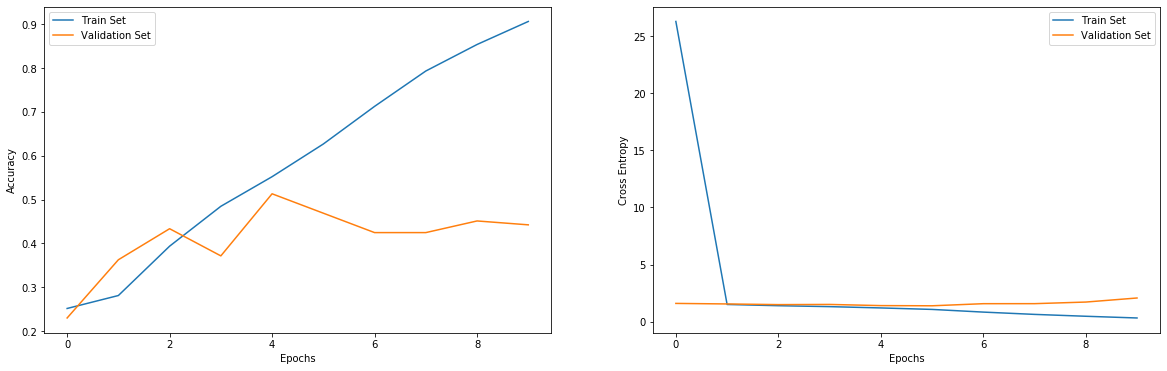

In [8]:
plot_training_curves(train_log)

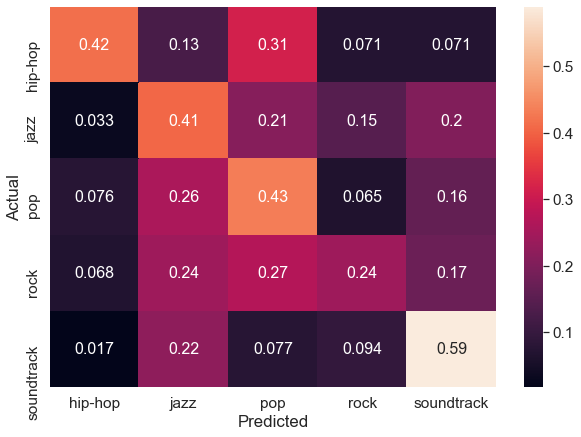

In [9]:
confusion_plot(y_test, y_predict)

From the above graphs, we can conclude that the model is severely overfitting to the data. For CNNs, there are several ways to avoid overfitting such as:

 * Changing the activation functions at the hidden layers.
 * Increasing or decreasing the number of nodes/filters in our hidden layers.
 * Modifying the number of layers in the CNN.
 * Applying regularization techniques (l1, l2, early stopping, etc.) while training the model.
 * Adding more music data.
 
However, there are several issues when trying to prevent overfitting. For example, if we combine the first four examples (see above), it involves finding the best hyperparameters that would give the best accuracy score so it would be a very time consuming process. Moreover, CNN models generally perform best when it is trained on a large dataset. Our dataset is about 2800 samples, so our model trained on that dataset would lead to overfitting.

The question now is, can we achieve a better accuracy using a CNN?

## Pretrained Convolutional Neural Network

In [12]:
#Coming Soon ...

#### Performance Evaluation For Pretrained CNN

In [13]:
#Coming Soon ...

## Modified Convolutional Network

In [10]:
#Coming Soon ...

#### Performance Evaluation For Modified CNN

In [11]:
#Coming Soon ...